<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/2_4_dcgan_faces_tutorial_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

「DCGANの実装チュートリアル  」
======

【原題】DCGAN Tutorial

【原著者】[Nathan Inkawhich](https://github.com/inkawhich)

【元URL】https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年12月06日

【チュトーリアル概要】

DCGANのモデル構造を詳細に説明しながら、実際にモデルを構築して、にせ物の人物画像を生成します。


DCGANチュートリアル 
===================


はじめに
----

本チュートリアルでは、DCGAN（Deep Convolutional GAN）について解説します。

具体的にはまず、実在する有名人の多数の写真をネットワークに訓練させ、その後、実在しない有名人風の画像を生成する敵対的生成ネットワーク(Generative Adversarial Network = GAN)を構築します。



本チュートリアルに掲載しているコードのうちほとんどは、[pytorch/example](https://github.com/pytorch/examples)で公開されているDCGANのコードです。

本チュートリアルではDCGANの実装について詳しく説明しますが、それだけでなく、このモデルがなぜ、どのように機能するのかという点についても説明します。

GANに関する予備知識は一切必要としないので、その点はご心配不要です。



ただし、初めてGANを体験する人は、GANで実際に何が起こっているのかをイメージするのに時間を要するかもしれません。

なお、実行時間を短縮することができるため、本ノートブックはGPU環境で利用することを推奨します。

それでは、基本的内容から解説を始めていきましょう。

GAN：生成的敵対的ネットワーク
--------------------------------

### GANとは？

GANは、学習データの分布を捉えるように、DLモデルを訓練するためのフレームワークです。

モデルがデータの分布を把握していれば、その分布を元に新しいデータを生成することができます。



GANは2014年にIan Goodfellowによって発明され、[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)という論文で最初に提示されました。

GANは、*生成器*と*識別器*と呼ばれる、2つの異なるモデルから構成されています。

生成器は、訓練画像に似た「偽の画像」を生成します。

識別器は、入力画像が本物の訓練画像なのか、生成器から出力された偽の画像なのかを識別します。

訓練中、生成器はより優れた偽物を次々と生成して識別器を騙そうとします。

一方で識別器はより優れた真贋の鑑定士となって、本物と偽物の画像を正しく分類しようとします。



生成器が訓練データから取得したように見える「完璧な偽物」を生成した時、この「偽画像生成 vs 正しい画像識別」のゲームは均衡状態になります。

このとき、識別器は生成器が生成した画像が本物か偽物かを、常に50%の信頼度で推測することになります。

それではここからは、チュートリアルで使用する数式を確認していきましょう。

まずは、**識別器**に関する数式です。

$x$というデータは、ここでは画像データを表します。

$D(x)$は、$x$が訓練データである確率（≒生成器による出力では**無い**確率）をスカラー値で出力する識別用のネットワークです。

今回は画像を扱っているので、$D(x)$に対する入力は、サイズが3x64x64（C×H×W）の画像となります。

$D(x)$が出力する確率は、$x$が訓練データから取得された場合は高い値が良く、$x$が生成器から出力される場合は低い値が良い、という点が、直感的に分かるかと思います。

このことから、$D(x)$は、一般的な二値分類器と考えることもできます。

続いて**生成器**に関する数式について記載します。

$z$は、標準正規分布からサンプリングされた潜在空間ベクトルです。

$G(z)$は、$z$を画像データ空間に写像する生成関数を表します（日本語訳注：ベクトル$z$を、画像データに変換するイメージです）。


$G$の目標は、訓練データのサンプリング元となっている真の確率分布($p_{data}$)を推定することです。

訓練データの確率分布を推定することができれば、その推定された分布($p_{g}$)から偽のサンプル画像を生成することができます。	

したがって、 $D(G(z))$の出力値は、生成器$G$の出力が本物の画像である（と、識別機$D$が予測した）確率を意味します。

[Goodfellow氏による論文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)に書かれているように、$D$と$G$は、次のようなMinimaxゲームをしています。

（日本語訳注：Minimaxゲームは、相手がベストな選択をすると想定したうえで、こちらの損失を最小にすることを目指すゲームです。）

<br>

すなわち、$D$は、本物と偽物を正しく分類する確率($logD(x)$)を最大化しようとします。


そして $G$は、$D$が偽物だと当てる確率（$log(1 - D(G(z)))$）を最小化しようとします。【コメント：英文ではG(x)になっていましたが、日本語版では修正】



論文から引用すると、GANの損失関数は次の式で表されます。

$\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}$

理論的には、このMinimaxゲームの解は$p_{g} = p_{data}$となる地点です。

この時、識別器は入力が本物か偽物かをランダムに推測します。

（日本語訳注：$p_g$はGが生成する偽画像の確率分布で、$p_{data}$は訓練画像の確率分布なので、この二つの分布が等しくなる時、$D$には偽物と本物の違いが分からなくなるため、ランダムに推測するのと同じ状態になります。）

<br>

しかし、GANの収束理論は今なお研究が活発な途上のテーマであり、必ずしも$p_{g} = p_{data}$となる地点まで訓練されるのがベストではありません。

### DCGANとは？

DCGANは、ここまで解説したGANの内容そのまま拡張し、識別器$D$に畳み込み層、生成器$G$に逆畳み込み層を明示的に使用していた手法です。

DCGGANは、Radfordらによる論文「[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](<https://arxiv.org/pdf/1511.06434.pdf)」で最初に提案されました。






**識別器$D$**は、ストライド付き[畳み込み](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)層、[バッチ正規化](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)層、および活性化関数[LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU)で構成されています。

識別器$D$の入力は3x64x64（C×H×W）の画像です。

識別器$D$の出力は、入力画像が真の分布からサンプリングされた確率（スカラー値）となります。

（日本語訳注：イメージしづらい場合、「訓練データである確率」と考えると理解しやすいかもしれません。）




**生成器$G$**は、[逆畳み込み](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d) 層、バッチ正規化層、活性化関数[ReLU](https://pytorch.org/docs/stable/nn.html#relu)で構成されています。

生成器$G$の入力は潜在ベクトル$z$で、これは標準正規分布からサンプリングされたものです。

そして生成器の出力は3x64x64（C×H×W）のRGB画像になります。

ストライド付き逆畳み込み層により、潜在ベクトルを画像と同じ形式のデータに変換することができます。

（日本語訳注：単なるベクトルである$z$の形をどんどん変化させ、3x64x64にまで変形します。）

<br>

この論文ではオプティマイザの設定方法、損失関数の計算方法、モデル重みの初期化方法についてのTipsも紹介されていますが、これらについては次のセクションで説明します。


In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 再現性のためにrandom seedを設定する
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 新たな結果を得たい場合に使用する
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


入力 
----

まずは、実行するために必要な以下の入力値を定義しましょう。

-   **dataroot** -<br>
    データセットフォルダのルート・ディレクトリへのパスです。
    データセットについては次のセクションで詳しく説明します。
-   **workers** -<br>
     `DataLoader`でデータを読み込むためのワーカースレッドの数です。
-   **batch\_size** -<br>
    訓練に使用するバッチサイズです。DCGAN論文ではバッチサイズとして128を使用しています。
-   **image\_size** -<br>
    学習に使用される画像の高さと幅のサイズです。<br>
    本チュートリアルでのデフォルトは 64x64となっています。<br>
    別のサイズの画像が必要な場合は、DとGの構造を変更する必要があります。詳細は[こちら](https://github.com/pytorch/examples/issues/70)を参照してください。
-   **nc** - <br>
    入力画像のカラーのチャネル数です。カラー画像の場合は3になります。
-   **nz** -<br>
     潜在ベクトルの長さです。
-   **ngf** -<br>
    生成器を伝播する特徴マップの深さです。
-   **ndf** - <br>
    識別器を伝搬する特徴量マップの深さです。
-   **num\_epochs** -<br>
    訓練時に実行するエポック数です。
    よりエポック数を増やして訓練を行うとより良い結果が期待できますが、より訓練に時間がかかります。
-   **lr** -<br>
    訓練のための学習率です。
    DCGAN論文で説明されているように、この数値は0.0002にすることが推奨されます。
-   **beta1** -<br>
    オプティマイザ：Adamのためのβ1ハイパーパラメータです。
    論文に記載されているように、この数値は0.5が推奨です。
-   **ngpu** - <br>
    利用可能な GPUコア数です。
    これが0の場合、コードはCPUモードで実行されます。
    この数値が 0より大きい場合、その数の GPU で実行されます。

In [ ]:
# データセットのルートディレクトリ
dataroot = "data/celeba"  # 後で、日本語版では修正します

# dataloaderのワーカー数
workers = 2

# 訓練中のバッチサイズ
batch_size = 128

# 訓練画像の高さと幅のサイズ
# 全ての画像は変換器を使ってこのサイズにリサイズされます。
image_size = 64

# 訓練画像のチャンネル数。カラー画像の場合は3。
nc = 3

# 潜在ベクトルzのサイズ (すなわち,、生成器に入力されるベクトルのサイズ)
nz = 100

# 生成器を伝播する特徴マップのサイズ
ngf = 64

# 識別器を伝播する特徴量マップのサイズ
ndf = 64

# 訓練エポック数
num_epochs = 5

# オプティマイザの学習率
lr = 0.0002

# オプティマイザ：Adamのハイパーパラメータ Beta1の値
beta1 = 0.5

#  利用可能なGPUの数。CPUモードの場合は0を使用。
ngpu = 1

データ 
------

本チュートリアルでは、[Celeb-A Facesデータセット](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) を使用します。

このデータセットはリンク先のサイト、または[Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)からダウンロードできます。

ダウンロードするデータセットのファイル名は、**img\_align\_celeba.zip** です。

（約1.4GBあります）

ダウンロードしたら、*celeba*という名前のディレクトリを作成し、そのディレクトリにzipファイルを展開しましょう。

そして、先ほど掲載したコードの`dataroot`変数に作成した*celeba*ディレクトリを設定します。

ディレクトリ構造は以下のようになるはずです。

```
/path/to/celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
```

後に続く作業をするためには、上記のようなディレクトリ構造でデータを用意しておくことが重要です。

なぜなら、この後利用する`dataset.ImageFolder`クラスでは、`dataset`のルートディクトリ配下のサブディレクトリとして、上記に示すディレクトリ構造を要件とするためです。




さて、ここまでのステップが完了すれば、データセット作成、データローダー用意、実行するデバイス設定、トレーニングデータの一部可視化、が実施できるようになります。

In [ ]:
# 日本語版では、Google DriveとGoogle Colabを連携させてファイルを扱う手法を解説します。
# 1. ダウンロードした、img_align_celeba.zip（1.4GB）を、自身のGoogle Driveにフォルダ「celeba」を作成し配置してください
# 2. ノートブックの左端の上から4つ目、フォルダマーク→右端の「ドライブをマウント」をクリックし、Google Driveをマウントしてください
# 3. 以下にセルが出現し、実行します。すると、Google Driveと連携させるパスコードが出るので、コピーして貼り付け認証します。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 4. これで'/content/drive'へとパスが通りました。
# 5. /content/drive/MyDrive/celeba/img_align_celeba.zip　を解凍します

In [ ]:
# 解凍先フォルダを作成
%mkdir "drive/MyDrive/celeba/data"


In [ ]:
# zipを解凍　※celebaは202,599枚の画像があるので、4万枚ほど解凍できたら止めるのが良いです。チュートリアルなので・・・
!unzip  "drive/MyDrive/celeba/img_align_celeba.zip" -d "drive/MyDrive/celeba/data/"

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039240.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039241.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039242.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039243.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039244.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039245.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039246.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039247.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039248.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039249.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039250.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039251.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039252.jpg  
 extracting: drive/MyDrive/celeba/data/img_align_celeba/039253.jpg  
 e

In [ ]:
# 最後に切れたファイルを消しておく
!rm "drive/MyDrive/celeba/data/img_align_celeba/044240.jpg"

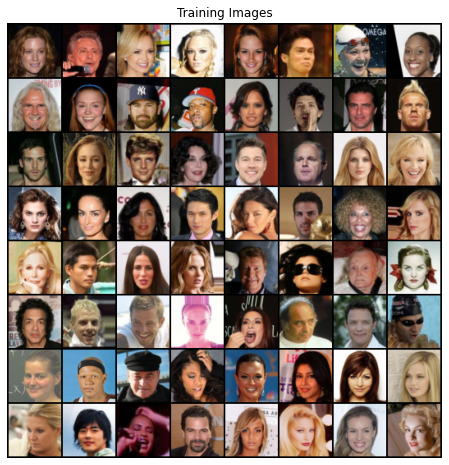

In [ ]:
# 画像フォルダのデータセットを設定した方法で使用できます。
# datasetオブジェクトの作成

dataroot = "drive/MyDrive/celeba/data/"  # 日本語版の修正に合わせてパスを変更

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloaderオブジェクトの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)  # 日本語版drop_last=Trueを追記しています

# どのデバイスで実行するかを決める
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# トレーニング画像をプロット
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

実装 
----------

入力パラメータの設定をし、データセットの準備もできたので、いよいよ実装に入ります。

以下では、重みの初期化、生成器、識別器、損失関数、学習ループという順番で、詳しく説明していきます。

### 重みの初期化

DCGANの論文上で著者らは、平均0、標準偏差0.02の正規分布からランダムにサンプリングした値を使い、すべてのモデルの重みを初期化するように指定しています。

<br>

以下に実装する`weights_init`関数は、既に一度重みを初期化したモデルを入力として受け取ります。

そして平均0、標準偏差0.02という基準を満たすように、すべての畳み込み層、逆畳み込み層、バッチ正規化層を再び初期化します。

この関数は、初期化直後のモデルに適用することになります。

In [ ]:
# カスタムの重み初期化用関数。netGとnetDで呼び出される
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 生成器 

生成器$G$は、潜在空間ベクトル($z$)を訓練データ空間に写像します。

今回のデータは画像なので、$z$をデータ空間に写像することは、最終的に訓練画像と同じサイズ（3x64x64）のRGB画像を作成することを意味します。

このようなデータの変換は、実装上は、二次元の逆畳み込み層を繰り返すことで実現されます。

<br>

そして、それぞれの逆畳み込み層は、二次元バッチ正規化層およびRelu活性化関数とセットになっています。

最後に、値の範囲を入力データと同じ$\lbrack - 1,1\rbrack$に戻すために、生成器の出力をtanh関数に通します。

ここで、逆畳み込み層の後にバッチ正規化関数が存在していることは注目すべき点であり、この点はDCGAN論文による重要な貢献です。

これらのバッチ正規化層によって、学習中の勾配の流れがスムーズになります。



DCGAN論文の生成器のイメージを以下に示します。

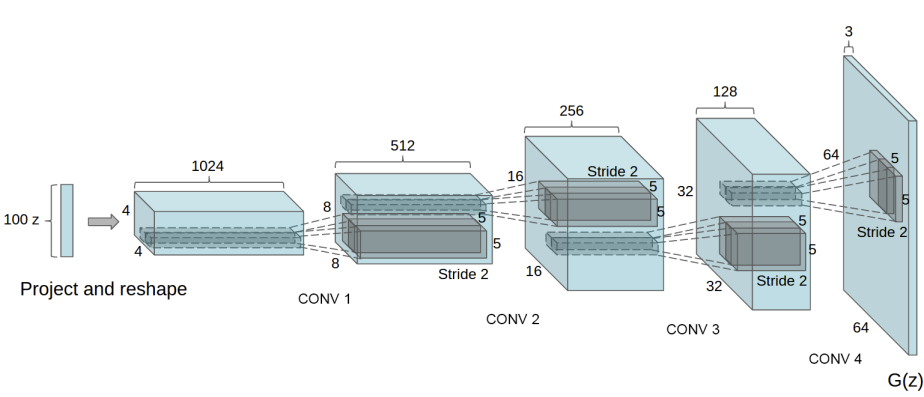

以下に掲載しているコード内で、本チュートリアルの「入力」セクションで定義した各変数（*nz*、*ngf*、*nc*）が、生成器のアーキテクチャにどのように影響しているのか、注目してください。

`nz`は入力ベクトル$z$の長さ、`ngf`は生成器を伝搬する特徴マップのサイズ、`nc`は出力画像のチャンネル数（RGB画像の場合は3に設定）を表しています。

#### 生成器の実装コード

In [ ]:
# 生成器コード

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力値はZで、畳み込みが適用されます
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # サイズ：(ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # サイズ：(ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # サイズ：(ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # サイズ：(ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # サイズ： (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

これで、生成器オブジェクトを作成し、そのオブジェクトに`weights_init`関数を適用できるようになりました。

生成器オブジェクトをprintをし、どのような構造になっているか確認してください。

In [ ]:
# 生成器オブジェクトを作成する
netG = Generator(ngpu).to(device)

# 必要に応じてマルチCPUを扱う
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netG.apply(weights_init)

# モデルをprint出力する
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 識別器

本チュートリアル内で既に記載したとおり、識別器$D$は画像を入力とし、その入力画像が（偽物ではなく）本物である確率をスカラー値で出力する二値分類ネットワークです。

<br>

本チュートリアルでは、識別器$D$はまず3x64x64（C×H×W）の入力画像を受け取ります。

そして、いくつかの畳み込みのブロックに伝播させることで、入力画像を処理します。

それぞれの畳み込みブロックは、`Conv2d`層、`BatchNorm2d`層、`LeakyReLU`層の3層で構成されています。

最後に、データを`Sigmoid`活性化関数に通して、最終的な確率を出力します。

<br>

必要に応じて層を追加することで、このアーキテクチャを拡張することも可能ですが、`Conv2d`（ストライド付き畳み込み）、`BatchNorm`（バッチ正規化）、`LeakyReLU`（活性化関数）の使用には、特別な狙いがある点には注意してください。




まずストライド付き畳み込みを用いてダウンサンプルを行う点についてですが、この操作によって、ネットワークは独自のプーリング関数を学習することができるようになります。

したがって単にプーリングをするよりも、ストライド畳み込みの方が優れた方法である旨がDCGANの論文上で述べられています。

また、バッチ正規化とLeaKey relu関数は、生成器$G$と識別器$D$の双方にとって非常に重要な「勾配の伝播」を安定化させる働きをします。

#### 識別機の実装コード

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力は (NC) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

続いて生成器の時と同様に、識別器オブジェクトを作成し、`weights_init`関数を適用した後、print文でモデルの構造を表示します。




In [ ]:
# 識別器を作成する
netD = Discriminator(ngpu).to(device)

# 必要に応じてマルチCPUを扱う
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netD.apply(weights_init)

# モデルをprint出力する
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### 損失関数とオプティマイザー

 識別器$D$と生成器$G$を学習させるための準備として、損失関数とオプティマイザを使い、どのように学習するかを指定します。



損失関数として、ここではPyTorchで定義されている以下のBinary Cross Entropy loss（[BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)）関数を使用します。


$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$






GANの損失関数の両方の対数成分（$log(D(x))$と$log(1 - D(G(z)))$)の算出に、このBCE関数がどのように利用されることになるか考えてみましょう。

（日本語訳注：GANの損失関数は  $\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}$  です。）

<br>

BCE関数の一部（具体的には$y$）は、値を指定することが可能です。

本チュートリアルでこの後に出てくる訓練ループでは、実際にBCE関数の$y$を指定する形で実装をしています。

ですがここでは、$y$(つまり正解ラベル)を変更することで、どのように算出する損失関数の成分を選択できるのかを理解することが重要です。



損失関数を設定した後、本物のラベルを1、偽物のラベルを0として定義します。 

このラベルは、識別器$D$と生成器$G$の損失を計算する際に用いられます。

なお、このラベルのつけ方はオリジナルのGAN論文でも使用されています。

<br>

最後に、識別器$D$と生成器$G$それぞれに、独立したオプティマイザーを設定します。

DCGAN論文で指定されているように、どちらも学習率0.0002、Beta1 =0.5のAdamを利用します。

<br>

生成器の訓練の進行状況を確認するために、ガウス分布から抽出された潜在ベクトルの固定ノイズバッチ（すなわち`fixed_noze`）を作成します。

訓練ループではこの`fixed_noise`を定期的に生成器$G$に入力し、イテレーションを重ねるなかでノイズから画像が形成されていく様子を確認することができます。

In [ ]:
# BCELoss関数の初期化
criterion = nn.BCELoss()

# 生成器の訓練の進行状況を可視化するために使用する潜在ベクトルのバッチを作成
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 訓練中に利用する本物と偽物のラベルを設定
real_label = 1.
fake_label = 0.

# GとDの両方にオプティマイザ：Adamを設定する
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### 訓練

GANフレームワークのすべての内容を定義、実装したので、ついにモデルの訓練ができるようになりました。

GANの訓練には、やや芸術的な側面がある点に注意してください。

というのも、間違ったハイパーパラメータを設定しても、モデルは何が間違っているのか説明しれくれず、バランスが崩壊した画像をただただ生成するだけだからです。

ここでは、Goodfellowの論文における Algorithm 1に忠実に従うと同時に、[ganhacks](https://github.com/soumith/ganhacks)で示されたいくつかのベストプラクティスを遵守します。

すなわち、「本物と偽物のためにそれぞれ異なるミニバッチを構築」し、$logD(G(z))$を最大化するようにGの目的関数を最適化します。

訓練は、主に 2つの部分に分かれます。

パート1では識別器を更新し、パート2は生成器を更新します。

**パート1 - 識別器の訓練**

思い出してみると、識別機を訓練する際の目標は「入力画像の真偽を正しく分類する確率の最大化」でした。

つまり、Goodfellowの言葉を借りれば「確率勾配上昇法で識別機を更新」していきたい、ということです。



今回、実際に最大化する関数は、$log(D(x)) + log(1 - D(G(z)))$です。

ミニバッチを分けるというganhacksで提案されたテクニックを踏まえ、2つのステップでこれを計算します。

一つ目のステップでは、訓練セットから実際のサンプルのバッチを作成し、$D$を順伝播させ、損失($log(D(x))$)を計算し、逆伝播を通じて勾配を算出します。

（日本語訳注：一つ目のステップでは本物画像だけを使って識別機の訓練だけを行うことを意味しています。）

二つ目のステップでは、現在の生成器を用いて偽のサンプルのバッチを作成し、このバッチを順伝播で$D$を通過させ、損失($log(1 - D(G(z)))$)を計算し、逆伝播させて勾配を保持します。

（日本語訳注：二つ目のステップでは偽の画像だけを使って識別機の訓練を行うことを意味しています。）

二つのステップを経て、全ての本物のバッチと、すべての偽物のバッチの両方の勾配が蓄積された状態となったので、ここで識別器のオプティマイザのステップを呼び出します。

**パート2 - 生成器のトレーニング** 

[GANのオリジナル論文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)で述べられていたように、生成器の訓練では、より優れた偽物を生成するために損失$log(1 - D(G(z)))$を最小化します。

先述のようにGoodfellowによって、特に学習プロセスの初期段階において、この損失の形では十分な勾配が得られないことが示されました。

（日本語訳注：先述の「確率的勾配上昇法で識別機を更新」という部分が該当箇所です）

この問題を修正するために、損失$log(1 - D(G(z)))$を最小化するのではなく、$log(D(G(z)))$を最大化しています。

以下に掲載しているコードでは、これを実現するために、以下のようなステップで処理を行っています。

まずパート1の生成器$G$が生成した画像を、識別器$D$で分類します。

次に本物の画像を表すラベル（$GT$とします）を使って、生成器$G$の損失を計算します。

そして逆伝播で生成器$G$の勾配を計算し、最後にオプティマイザーのステップで生成器Gのパラメータを更新します。

本物画像を示すラベル（$GT$）を損失関数で使用するのは直感に反するかもしれません。

しかしこれによって、使おうとしていたBCELossのパーツ$log(x)$を（$log(1 - x)$ではなく）使うことができます。


最後に、指標を記録し、各エポックの終わりに、固定ノイズのバッチ（`fixed_noise`）を生成器に投入して、Gの学習の進捗履歴を可視化します。




ここで記録する訓練時の統計量は以下の通りです。

- **Loss\_D**

  識別器Dの損失です。全ての本物画像のバッチと、全ての偽画像のバッチの損失の合計として計算されます。<br>
    具体的には、次の式で算出されます。

  $log(D(x)) + log(D(G(z)))$

-   **Loss\_G** - <br>
    生成器の損失で、次のように計算されます。<br>
  $log(D(G(z)))$
-   **D(x**) -<br>
    全ての本物画像のバッチに対する識別器による出力値の（バッチ全体の）平均です。<br>
    最初は1に近い値で始まり、理論的には生成器$G$の性能が向上すると0.5に収束します。<br>
    なぜこのような形で収束するのかは、考えてみてください。
-   **D(G(z**)) - <br>
    全ての偽画像のバッチに対する識別器による出力値の平均です。<br>
    最初に出力される値は、識別器$D$が更新される前に出力されることになります。<br>
    そして、２番目の値は、識別器Dのパラメータが更新された後に出力されます。<br>
    この数値は0付近から始まり、生成器$G$の性能が向上するにつれて0.5に収束します。<br>
    なぜこのような形で収束するのかは、考えてみてください。

<br>

**注意:**<br>
実行するエポック数や、データセットからデータを削除するか否かによって、このステップの実行には時間がかかるかもしれません。

In [ ]:
# 訓練のループ

# 訓練の進捗状況を把握するためのリスト
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 各エポックについて
for epoch in range(num_epochs):
    # dataloader内の各バッチについて
    for i, data in enumerate(dataloader, 0):
        
        ############################
        #  (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        ## 本物画像のバッチを使った訓練
        netD.zero_grad()
        # バッチの形式をランタイムに合わせる
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # 本物画像のバッチをDに順伝播させる
        output = netD(real_cpu).view(-1)
        # 全ての本物画像のバッチの損失を計算する
        errD_real = criterion(output, label)
        # 逆伝播で勾配を計算する
        errD_real.backward()
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        # 潜在ベクトルのバッチを生成
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Gを使って、偽画像のバッチを生成
        fake = netG(noise)
        label.fill_(fake_label)
        # Dを使って、全ての偽画像を分類
        output = netD(fake.detach()).view(-1)
        # 全ての偽画像に対するDの損失を計算
        errD_fake = criterion(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 生成器の損失にとっては、偽画像ラベルが正解になる
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        output = netD(fake).view(-1)
        # この出力に対するGの損失をもう一度計算
        errG = criterion(output, label)
        # Gの勾配を計算
        errG.backward()
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # あとでプロットするために損失を保存
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # 生成器Gの出力をfixed_noiseに保存して、生成器の動作を確認
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/345]	Loss_D: 2.4375	Loss_G: 4.5938	D(x): 0.4807	D(G(z)): 0.7152 / 0.0174
[0/5][50/345]	Loss_D: 0.5131	Loss_G: 11.4752	D(x): 0.9534	D(G(z)): 0.2686 / 0.0000
[0/5][100/345]	Loss_D: 0.3697	Loss_G: 10.0620	D(x): 0.9163	D(G(z)): 0.1790 / 0.0002
[0/5][150/345]	Loss_D: 0.3855	Loss_G: 4.9955	D(x): 0.9159	D(G(z)): 0.2168 / 0.0164
[0/5][200/345]	Loss_D: 0.4429	Loss_G: 5.7390	D(x): 0.7230	D(G(z)): 0.0198 / 0.0081
[0/5][250/345]	Loss_D: 1.0064	Loss_G: 3.4874	D(x): 0.5224	D(G(z)): 0.0233 / 0.0641
[0/5][300/345]	Loss_D: 0.3316	Loss_G: 5.1513	D(x): 0.8846	D(G(z)): 0.1390 / 0.0111
[1/5][0/345]	Loss_D: 0.4603	Loss_G: 4.9110	D(x): 0.8480	D(G(z)): 0.2007 / 0.0110
[1/5][50/345]	Loss_D: 1.5265	Loss_G: 10.9069	D(x): 0.9412	D(G(z)): 0.6691 / 0.0002
[1/5][100/345]	Loss_D: 0.2946	Loss_G: 4.5239	D(x): 0.8712	D(G(z)): 0.1154 / 0.0170
[1/5][150/345]	Loss_D: 0.2824	Loss_G: 3.8038	D(x): 0.8450	D(G(z)): 0.0488 / 0.0493
[1/5][200/345]	Loss_D: 1.0354	Loss_G: 10.1791	D(x): 0.9704	D(G(z

結果 
----

最後に、どのような結果になったのかを確認してみましょう。

ここでは、三つの結果を確認します。

一つ目に、訓練中に識別器$D$と生成器$G$の損失がどのように変化したかを確認します。

二つ目に、固定ノイズ（`fixed_noise`）のバッチに対する生成器$G$の出力をエポックごとに可視化します。

そして三つ目に、本物のデータのバッチの隣に、生成器$G$が出力する偽データのバッチを配置して確認してみましょう。

**訓練イテレーションごとの損失**

下のグラフは、訓練におけるイテレーションごとの、識別器$D$ と 生成器$G$の損失をプロットしたものです。

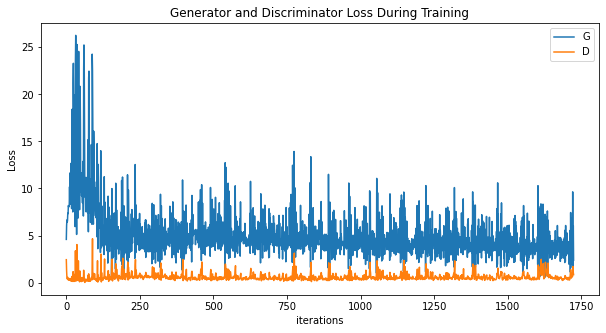

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

（日本語訳注：全てのサンプル画像を使って訓練を行った例を以下に掲載します。）
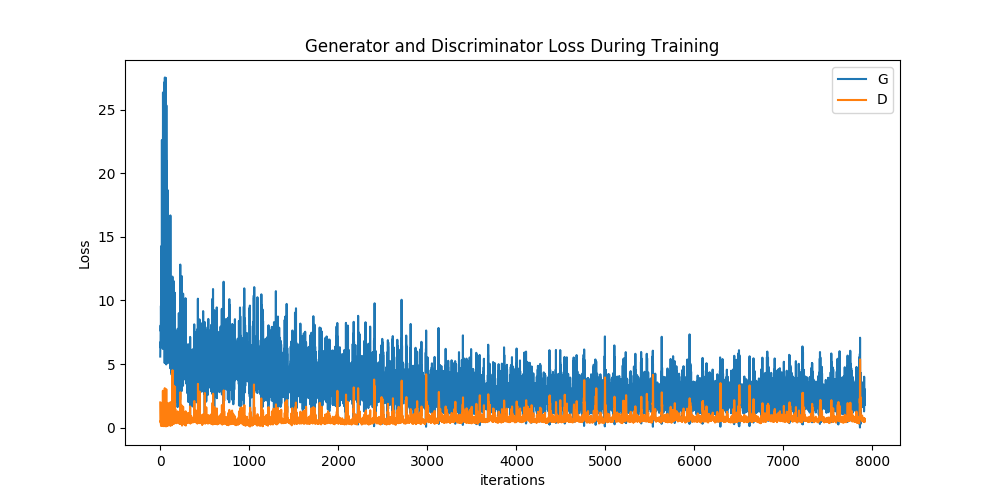

**生成器$G$の訓練進行状況の可視化**

訓練のエポックごとに、固定ノイズ（`fixed_noise`）バッチに対する生成器の出力を保存していました。

ここで、アニメーションを使って生成器$G$の学習の進行状況を可視化してみましょう。

再生ボタンを押すとアニメーションが始まります。

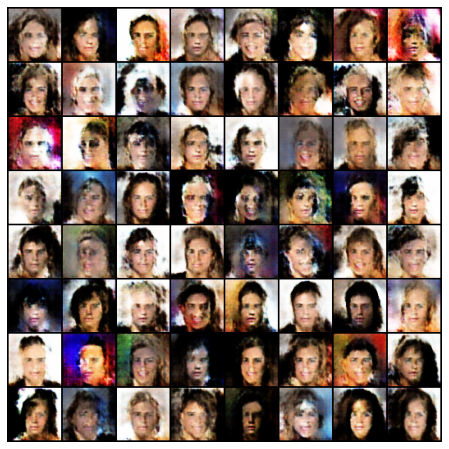

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

（日本語訳注：全てのサンプルデータを使って訓練を行った例を以下に掲載します）
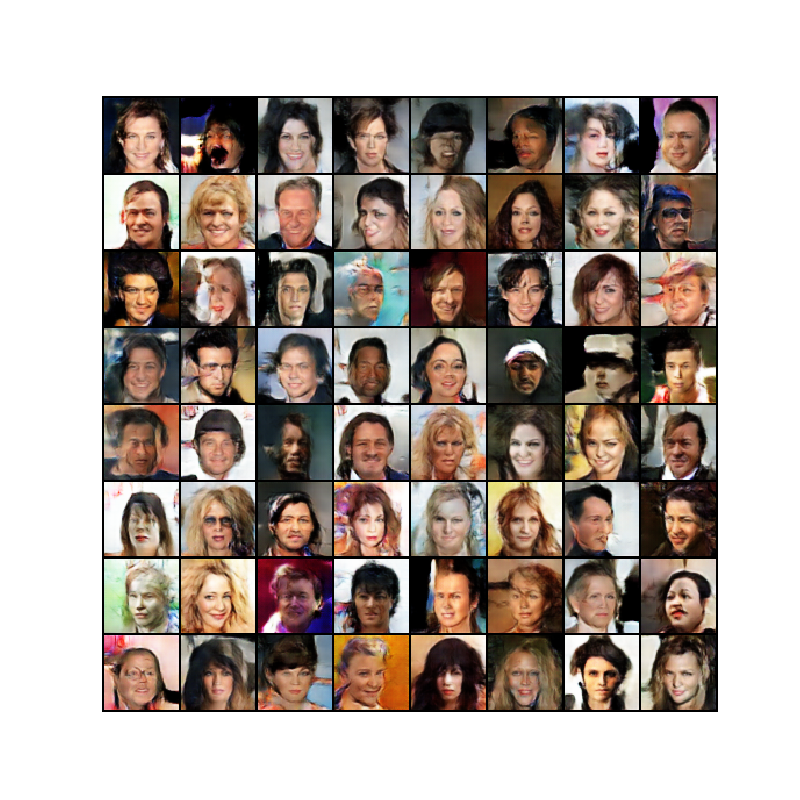

**本物の画像と偽物の画像**

最後に、本物の画像と偽物の画像を並べて確認してみましょう。

（日本語訳注：全てのサンプル画像を使って訓練を行った場合の例を以下に掲載します。）


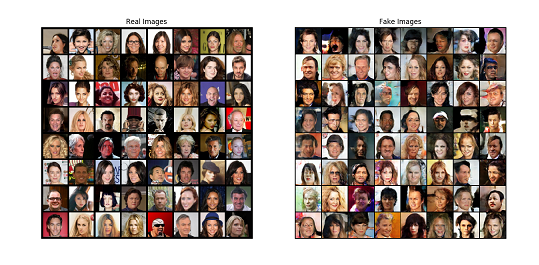

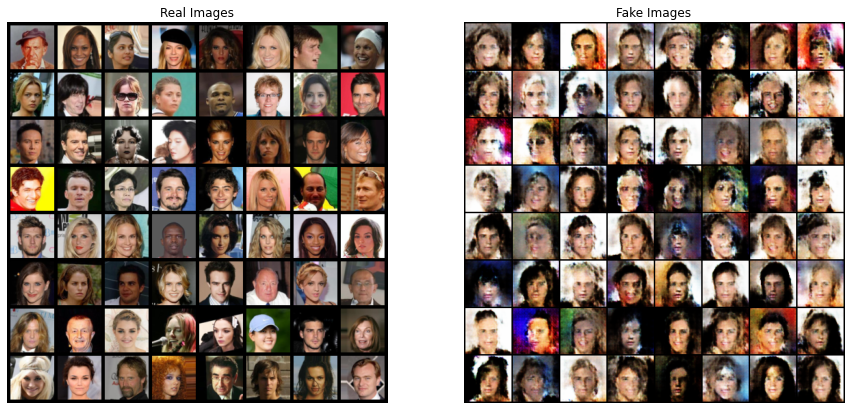

In [ ]:
# dataloaderから本物の画像を取得する
real_batch = next(iter(dataloader))

# 本物画像をプロット
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 最後のエポックから偽物画像をプロットする
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

【日本語訳注】

今回はチュートリアル実行の時間を減らすため、20万枚の画像ではなく、4万枚ほどで実施しました。

興味がある方は、20万枚全てを使用した実施も試みてください。


ネクスト・ステップ
------------

本チュートリアルは以上となります。この後のステップとしては、以下のような方向性があります。

-   モデルをさらに長時間訓練させて、結果がどれくらい改善するかを確認する
-   別のデータセットを取得したり、画像のサイズとモデルアーキテクチャを変更することで、このモデルを修正する
-   [ここから](https://github.com/nashory/gans-awesome-applications)、他の優れたGANプロジェクトをチェックしてみる
-   [音楽を生成するGAN](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)を作成してみる